In [ ]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.geodesic as geo
import cartopy.crs as ccrs # for projection

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [72]:
ltm = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/icec.mon.ltm.1991-2020.nc', 
                     chunks={'time':'500MB'})

ltm = ltm.sel(lat=slice(66,90),lon=slice(0,360))
ltm.isel(time=8)

/Users/shelbyfatcheric/anaconda3/envs/Capstone/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/shelbyfatcheric/anaconda3/envs/Capstone/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:             (lat: 96, lon: 1440, nbnds: 2)
Coordinates:
  * lat                 (lat) float32 66.12 66.38 66.62 ... 89.38 89.62 89.88
  * lon                 (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
    time                object 0001-09-01 00:00:00
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (nbnds) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    icec                (lat, lon) float32 dask.array<chunksize=(96, 1440), meta=np.ndarray>
    valid_yr_count      (lat, lon) float32 dask.array<chunksize=(96, 1440), meta=np.ndarray>
Attributes:
    Conventions:                    CF-1.5
    title:                          NOAA/NCEI 1/4 Degree Daily Optimum Interp...
    institution:                    NOAA/National Centers for Environmental I...
    source:                         NOAA/NCEI https://www.ncei.noaa.gov/data/...
    References:                     https://www.psl.noaa.gov/data/gridded/dat...
    dataset_title:                  NOAA Daily Optimum Interpolation Sea Surf...
    version:                        Version 2.1
    comment:                        Reynolds, et al.(2007) Daily High-Resolut...
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    _NCProperties:                  version=2,netcdf=4.7.0,hdf5=1.10.5,

In [73]:
import geopandas as gpd
sea_routes = gpd.read_file('Sea Routes.geojson')
sea_routes = sea_routes.drop(columns=['Id','OBJECTID'])
sea_routes['numbers'] = [1,2,3]
sea_routes

,Name,Shape_Leng,geometry,numbers
0,Northwest Passage,7689.630315,"LINESTRING (-168.83320 59.34944, -167.33377 62...",1
1,Northern Sea Route,7576.681873,"MULTILINESTRING ((180.00000 70.32357, 179.0842...",2
2,Transpolar,7137.175384,"LINESTRING (-169.78554 60.27749, -168.41041 62...",3


In [74]:
#Reproject data onto North Pole Azimuthal Equidistant CRS for accurate plotting: https://gis.stackexchange.com/questions/387091/how-to-plot-coordinate-system-from-epsg-4326-on-north-pole-centered-map-in-pytho
sea_routes_reproj = sea_routes.to_crs('+proj=aeqd +lat_0=90')

In [75]:
#Create variables with different levels of sea ice concentration for use identifying route trouble spots
ltm15 = ltm.where(ltm['icec']>0.15)
ltm25 = ltm.where(ltm['icec']>0.25)
ltm35 = ltm.where(ltm['icec']>0.35)
ltm45 = ltm.where(ltm['icec']>0.45)

Text(0.5, 1.0, 'Sep LTM ICEC >45%')

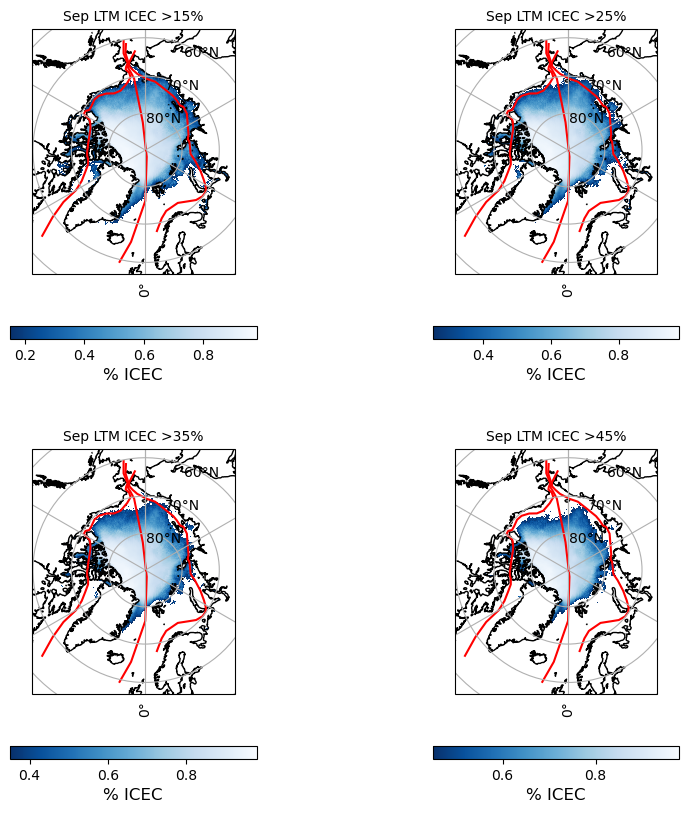

In [76]:
# Identify trouble spots by plotting the LTM at different concentrations to see where the most prolific ice areas are.
proj = ccrs.NorthPolarStereo()
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(2, 2, figsize=(10,10), subplot_kw=dict(projection=proj))

fill = ltm15.isel(time=8)['icec'].plot(ax=ax[0,0],transform=trans,cmap='Blues_r', add_colorbar=False)
sea_routes_reproj.plot(ax=ax[0,0],color='red')

gl1 = ax[0,0].gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
ax[0,0].coastlines()
cb1 = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb1.set_label('% ICEC', fontsize=12)
ax[0,0].set_title('Sep LTM ICEC >15%', fontsize=10)

fill = ltm25.isel(time=8)['icec'].plot(ax=ax[0,1],transform=trans,cmap='Blues_r', add_colorbar=False)
sea_routes_reproj.plot(ax=ax[0,1],color='red')

gl2 = ax[0,1].gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False
ax[0,1].coastlines()
cb2 = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb2.set_label('% ICEC', fontsize=12)
ax[0,1].set_title('Sep LTM ICEC >25%', fontsize=10)

fill = ltm35.isel(time=8)['icec'].plot(ax=ax[1,0],transform=trans,cmap='Blues_r', add_colorbar=False)
sea_routes_reproj.plot(ax=ax[1,0],color='red')

gl3 = ax[1,0].gridlines(draw_labels=True)
gl3.top_labels = False
gl3.right_labels = False
ax[1,0].coastlines()
cb3 = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb3.set_label('% ICEC', fontsize=12)
ax[1,0].set_title('Sep LTM ICEC >35%', fontsize=10)

fill = ltm45.isel(time=8)['icec'].plot(ax=ax[1,1],transform=trans,cmap='Blues_r', add_colorbar=False)
sea_routes_reproj.plot(ax=ax[1,1],color='red')

gl4 = ax[1,1].gridlines(draw_labels=True)
gl4.top_labels = False
gl4.right_labels = False
ax[1,1].coastlines()
cb4 = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb4.set_label('% ICEC', fontsize=12)
ax[1,1].set_title('Sep LTM ICEC >45%', fontsize=10)

NSR Ice Spot: 77-78 Lat, 92-115 Lon // 
NWP Ice Spot: 73-75 Lat, 240-268 Lon

In [ ]:
#Open datasets and keep only data associated with above identified trouble spots.
nsr_data = xr.open_dataset('nsr_data.nc', decode_times=True)
nsr_data = nsr_data.where(nsr_data.time.dt.month.isin(9), drop=True)
nsr_data = nsr_data.sel(lat=slice(77,78), lon=slice(92,115))

nwp_data = xr.open_dataset('nwp_data.nc', decode_times=True)
nwp_data = nwp_data.where(nwp_data.time.dt.month.isin(9), drop=True)
nwp_data = nwp_data.sel(lat=slice(73,75), lon=slice(240,268))

In [48]:
import shapely.geometry as sg

def trouble_spot_length(data):
### Calculate the geodesic length of a linear geometry given spatial data ###
    
    data = data.isel(time=0)

    condition = data['icec'].where(data['icec'].notnull())
    indexes = np.argwhere(np.array(condition.notnull()))

    points = []
    
    for i in range(len(indexes)):

        lat_index = indexes[i][0]
        lon_index = indexes[i][1]

        lat_val = float(data.isel(lat=lat_index).lat.values)
        lon_val = float(data.isel(lon=lon_index).lon.values)

        point = [lon_val,lat_val]
    
        if point not in points:
            points.append(point)

    points.sort()

    line = sg.LineString(points)
    line_gdf = gpd.GeoDataFrame(geometry=[line])
    line_gdf = line_gdf.set_crs('EPSG:4326') #set CRS to WGS84 for geodesic calculations

    ellipsoid = geo.Geodesic() #defaults to WGS84 radius/flattening values
    
    t_spot = line_gdf['geometry'][0]
    t_spot_leng = ellipsoid.geometry_length(t_spot)/1000

    return t_spot_leng

In [63]:
def perc_cover(dataset, route_length):
### Calculate percent ice cover of linear sea route during September of each year ###

    perc_cover = []

    for i in range(len(dataset['time'])): 
    
        data = dataset.isel(time=i)
        data = data.where(data['icec']>0.15, drop=True)

        condition = data['icec'].where(data['icec'].notnull())
        indexes = np.argwhere(np.array(condition.notnull()))

        points = []
    
        for i in range(len(indexes)):

            lat_index = indexes[i][0]
            lon_index = indexes[i][1]

            lat_val = float(data.isel(lat=lat_index).lat.values)
            lon_val = float(data.isel(lon=lon_index).lon.values)

            point = [lon_val,lat_val]
    
            if point not in points:
                points.append(point)

        points.sort()

        ice_line = sg.LineString(points)
        ice_line_gdf = gpd.GeoDataFrame(geometry=[ice_line])
        ice_line_gdf = ice_line_gdf.set_crs('EPSG:4326')

        ellipsoid = geo.Geodesic() #defaults to WGS84 radius/flattening values
    
        object = ice_line_gdf['geometry'][0]
        ice_cover = ellipsoid.geometry_length(object)/1000
    
        perc = ice_cover/route_length

        perc_cover.append(perc) #THIS IS THE GOAL VALUE

    return perc_cover

In [66]:
nsr_ts = trouble_spot_length(nsr_data)
nwp_ts = trouble_spot_length(nwp_data)

In [67]:
nsr_perc_cover = perc_cover(nsr_data, nsr_ts)
nwp_perc_cover = perc_cover(nwp_data, nwp_ts)

In [68]:
# period of interest
years = np.arange(1981, 2024)

In [ ]:
#Calculate best fit trends for linear and 2nd order polynomial functions
nsr_trend1 = np.polyfit(years, nsr_perc_cover, 1)
nsr_trend2 = np.polyfit(years, nsr_perc_cover, 2)
nsr_trendline1 = np.poly1d(nsr_trend1)
nsr_trendline2 = np.poly1d(nsr_trend2)

nwp_trend1 = np.polyfit(years, nwp_perc_cover, 1)
nwp_trend2 = np.polyfit(years, nwp_perc_cover, 2)
nwp_trendline1 = np.poly1d(nwp_trend1)
nwp_trendline2 = np.poly1d(nwp_trend2)

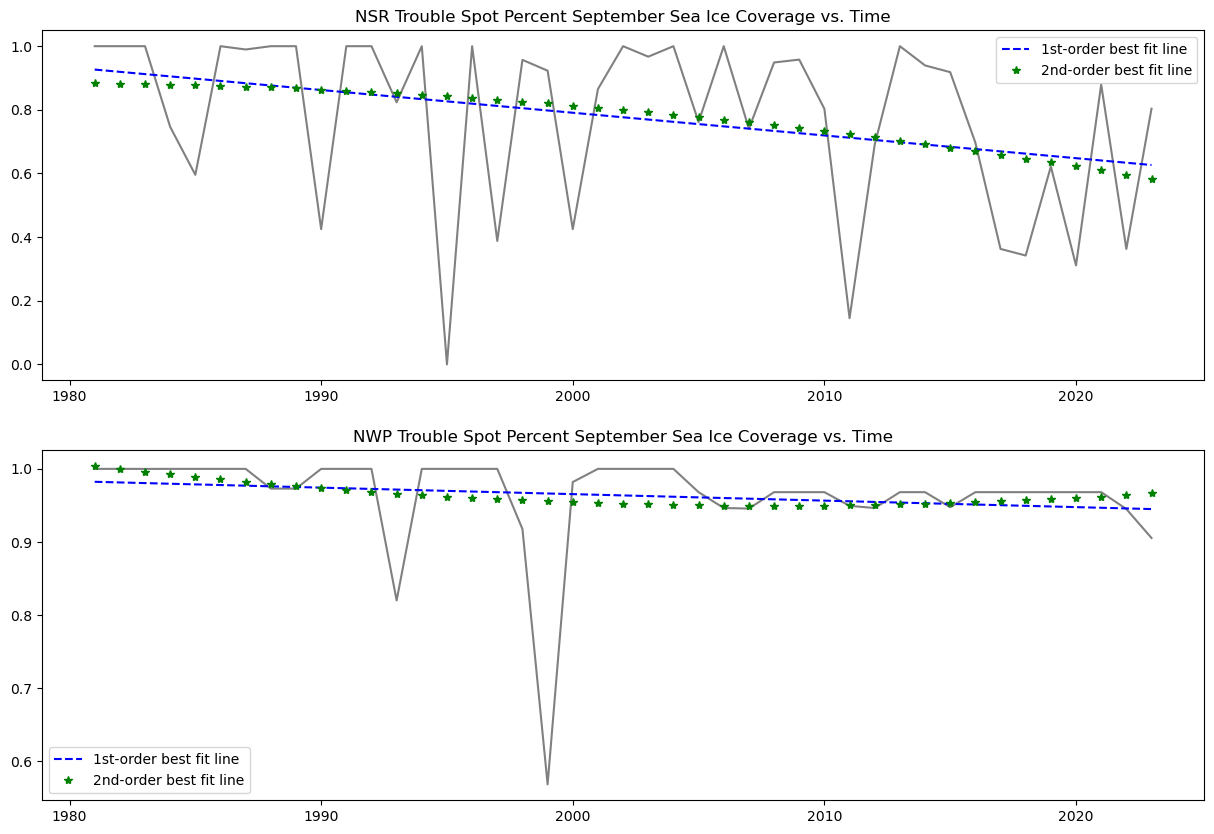

In [70]:
fig, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].plot(years, nsr_perc_cover, '-', color='gray')
ax[0].plot(years, nsr_trendline1(years), '--', color='blue', label='1st-order best fit line')
ax[0].plot(years, nsr_trendline2(years), '*', color='green', label='2nd-order best fit line')
ax[0].set_title('NSR Trouble Spot Percent September Sea Ice Coverage vs. Time')
ax[0].legend()

ax[1].plot(years, nwp_perc_cover, '-', color='gray')
ax[1].plot(years, nwp_trendline1(years), '--', color='blue', label='1st-order best fit line')
ax[1].plot(years, nwp_trendline2(years), '*', color='green', label='2nd-order best fit line')
ax[1].set_title('NWP Trouble Spot Percent September Sea Ice Coverage vs. Time')
ax[1].legend()

Add Trouble Spot Percent Cover values to percent coverage csv so all data is in the same place

In [34]:
perc_cover = pd.read_csv('perc_coverage_data.csv')

perc_cover.head()

,year,mo,arctic,nsr,nwp
0,1981,9,0.315789,0.512421,0.406556
1,1982,9,0.315078,0.488527,0.413474
2,1983,9,0.334282,0.497676,0.559853
3,1984,9,0.292319,0.412902,0.419400
4,1985,9,0.300853,0.403827,0.428258


In [36]:
perc_cover['nsr_spot'] = nsr_perc_cover
perc_cover['nwp_spot'] = nwp_perc_cover
perc_cover = perc_cover.set_index('year')
perc_cover.head()

,mo,arctic,nsr,nwp,nsr_spot,nwp_spot
year,,,,,,
1981,9,0.315789,0.512421,0.406556,1.000000,1.000000
1982,9,0.315078,0.488527,0.413474,1.000000,1.000000
1983,9,0.334282,0.497676,0.559853,1.000000,0.999947
1984,9,0.292319,0.412902,0.419400,0.746492,1.000000
1985,9,0.300853,0.403827,0.428258,0.595685,0.999988


In [37]:
perc_cover.to_csv('perc_coverage_data.csv')